# Strategy Details

### Code Author: Karl Ngan

Reference: Mathematical modeling and dynamic trading strategies for gold and bitcoin 


Link to reference: https://www.linkedin.com/posts/namnguyento_quantitativefinance-bitcoin-portfoliomanagement-activity-7173676442709377024-dIlp?utm_source=share&utm_medium=member_desktop

The main idea: Using the Holt-Winters model and the financial indicators to develop trading strategies on BTC and Gold market

In [103]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pandas_ta as ta

start_date = '2016-01-01'
end_date = '2024-10-31'

In [104]:
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start= start_date, end= end_date)

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

In [105]:
#Downloading the data from Yahoo Finance
gold = load_data('GC=F')[['Open' , 'Close']]
btc = load_data('BTC-USD')[['Open' , 'Close']]
lookback = 30
#changing the dates format
gold['date'] = gold.index
btc['date'] = btc.index
gold['date'] = pd.to_datetime(gold['date'], format='%Y-%m-%d').dt.date
btc['date'] = pd.to_datetime(btc['date'], format='%Y-%m-%d').dt.date
gold.set_index('date', inplace=True)
btc.set_index('date', inplace=True)


In [106]:
#daily returns
gold['daily_return'] = gold['Close'].pct_change()
btc['daily_return'] = btc['Close'].pct_change()



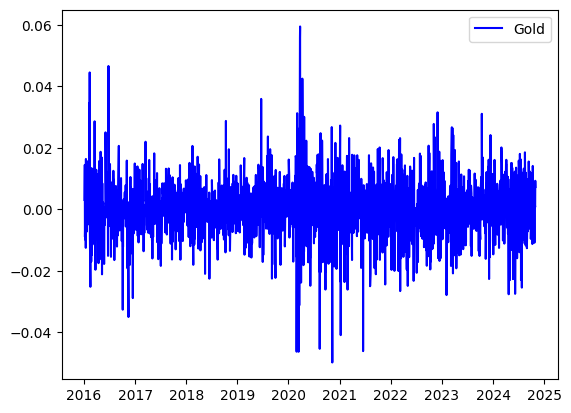

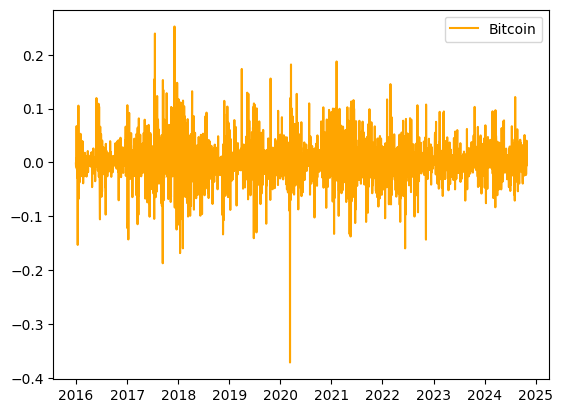

In [107]:
#plot the returns to see the data trend

plt.plot(gold['daily_return'], label='Gold', color='blue')
plt.legend()
plt.show()

plt.plot(btc['daily_return'], label='Bitcoin', color='orange')
plt.legend()
plt.show()

### Holt-Winters non-seasonal model


In [108]:
#define function for forecasting the price
def forecast_price(price):
    
    for i in range(len(price)):
        if i < lookback:
            continue

        #for the day i, we calculate the forecast value for the next day with pass 30 days data
        past_30_price = price['daily_return'].iloc[i-lookback:i]
        model = sm.tsa.ExponentialSmoothing(past_30_price, trend= None, damped_trend=False).fit()
        
        #forecast the next day return
        price['forecast'].iloc[i] = model.forecast(steps=1)
        
    return price


In [109]:
#forecast the price for gold and bitcoin
#ignore warning
import warnings
warnings.filterwarnings("ignore")

gold['forecast'] = np.nan
gold = forecast_price(gold)

btc['forecast'] = np.nan
btc = forecast_price(btc)

In [110]:
#checking the accruacy of the forecast at least on the direction of the price
#create new dataframe to store the forecasted direction
gold_acc = gold.copy()
gold_acc['forecast_direction'] = np.nan
gold_acc['forecast_direction'].loc[gold['forecast'] > 0] = 1
gold_acc['forecast_direction'].loc[gold['forecast'] < 0] = -1

gold_acc['actual_direction'] = np.nan
gold_acc['actual_direction'].loc[gold['daily_return'] > 0] = 1
gold_acc['actual_direction'].loc[gold['daily_return'] < 0] = -1
gold_acc['actual_direction'] = gold_acc['actual_direction'].shift(-1)

gold_acc['correct'] = np.nan
gold_acc['correct'].loc[gold_acc['forecast_direction'] == gold_acc['actual_direction']] = 1
gold_acc['correct'].loc[gold_acc['forecast_direction'] != gold_acc['actual_direction']] = 0

gold_acc.dropna(inplace=True)

gold_acc['correct'].value_counts()





correct
1.0    1098
0.0    1080
Name: count, dtype: int64

In [111]:

btc_acc = btc.copy()
btc_acc['forecast_direction'] = np.nan
btc_acc['forecast_direction'].loc[btc['forecast'] > 0] = 1
btc_acc['forecast_direction'].loc[btc['forecast'] < 0] = -1

btc_acc['actual_direction'] = np.nan
btc_acc['actual_direction'].loc[btc['daily_return'] > 0] = 1
btc_acc['actual_direction'].loc[btc['daily_return'] < 0] = -1
btc_acc['actual_direction'] = btc_acc['actual_direction'].shift(-1)

btc_acc['correct'] = np.nan
btc_acc['correct'].loc[btc_acc['forecast_direction'] == btc_acc['actual_direction']] = 1
btc_acc['correct'].loc[btc_acc['forecast_direction'] != btc_acc['actual_direction']] = 0

#drop if forecast is nan
btc_acc.dropna(inplace=True)
btc_acc['correct'].value_counts()


correct
1.0    1655
0.0    1538
Name: count, dtype: int64

In [112]:
#calculate the accuracy
print("Gold forecast accuracy: ", gold_acc['correct'].sum() / len(gold_acc))
print("Bitcoin forecast accuracy: ", btc_acc['correct'].sum() / len(btc_acc))

Gold forecast accuracy:  0.5041322314049587
Bitcoin forecast accuracy:  0.5183213279047917


 the forecast has around 50% accuracy rate only on both BTC and Gold prediction which is not ideal. It is beleive that the model fails as return is not stationary.
 
 But still, we may use this as reference and further develop new strategies based on it. 

## Trading Strategy 1 Overview:

If the predicted return is postive, we long in the next day, otherwise we short. No holding

In [113]:

#Gold Strategy 1
Gold_Strategy1_returns_holder = []
flag = 0
for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if gold['forecast'].iloc[i] > 0:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        #using ith price to predict and make decision on i+1th price
        Gold_Strategy1_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)
    else:
        if  flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy1_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)


Gold_Strategy1_Returns_df = pd.DataFrame(Gold_Strategy1_returns_holder)
Gold_Strategy1_Returns_df.columns = ['Gold_Strategy1_Returns']
Gold_Strategy1_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1
BTC_Strategy1_returns_holder = []
flag = 0 
for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    #if the forecasted price is higher than the current price, we buy
    if btc['forecast'].iloc[i] > 0:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        
        BTC_Strategy1_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)
            
    else:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy1_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

BTC_Strategy_Returns_df = pd.DataFrame(BTC_Strategy1_returns_holder)
BTC_Strategy_Returns_df.columns = ['BTC_Strategy1_Returns']
BTC_Strategy_Returns_df.index = btc.index[lookback+1:]


#Results    

results = pd.DataFrame(columns=['Mean', 'SD', 'Sharpe'])
results.loc['Gold_Strategy1'] = [Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std(), Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].mean()/Gold_Strategy1_Returns_df['Gold_Strategy1_Returns'].std()]
results.loc['BTC_Strategy1'] = [BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std(), BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].mean()/BTC_Strategy_Returns_df['BTC_Strategy1_Returns'].std()]

print(results)

                    Mean        SD    Sharpe
Gold_Strategy1 -0.000308  0.009168 -0.033646
BTC_Strategy1   0.001392  0.036413  0.038220


### Refining Strategy 1 

Oberving the results from Strategy 1, it is not profitable mainly due to the transaction cost and the errors on model.

Taking this into account, we are going to further refine the result with more conditioners.

In [114]:
#Not to trade if the price difference is smaller than the transaction cost
#Gold Strategy 1.5
Gold_Strategy1_5_returns_holder = []
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if gold['forecast'].iloc[i] > 0.0025:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)

    elif gold['forecast'].iloc[i] < -0.0025:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        Gold_Strategy1_5_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)
    
    else:
        Gold_Strategy1_5_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)

Gold_Strategy1_5_returns_df = pd.DataFrame(Gold_Strategy1_5_returns_holder)
Gold_Strategy1_5_returns_df.columns = ['Gold_Strategy1_5_Returns']
Gold_Strategy1_5_returns_df.index = gold.index[lookback+1:]


#BTC Strategy 1.5
BTC_Strategy1_5_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue

    #if the forecasted price is higher than the current price and the tx cost, we buy
    if btc['forecast'].iloc[i] > 0.0025 :
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

    elif btc['forecast'].iloc[i] < -0.0025:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0

        BTC_Strategy1_5_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    
    else:
        BTC_Strategy1_5_returns_holder.append(btc['daily_return'].iloc[i+1]*flag)

BTC_Strategy1_5_returns_df = pd.DataFrame(BTC_Strategy1_5_returns_holder)
BTC_Strategy1_5_returns_df.columns = ['BTC_Strategy1_5_Returns']
BTC_Strategy1_5_returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy1_5'] = [Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std(), Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].mean()/Gold_Strategy1_5_returns_df['Gold_Strategy1_5_Returns'].std()]
results.loc['BTC_Strategy1_5'] = [BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std(), BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].mean()/BTC_Strategy1_5_returns_df['BTC_Strategy1_5_Returns'].std()]

print(results)

                      Mean        SD    Sharpe
Gold_Strategy1   -0.000308  0.009168 -0.033646
BTC_Strategy1     0.001392  0.036413  0.038220
Gold_Strategy1_5 -0.000024  0.009116 -0.002584
BTC_Strategy1_5   0.000990  0.036446  0.027160


### Comments on the strategy 1
The strategy are not profitable mainly due to model's errors triggering the excess frequent long-short and the transaction cost associated.
We may use the financial indicators as conditioner to generate better signals 


## Trading Strategy 2 Overview:

Calculating the SMA for gold and BTC. if they cross, we change the position of signals.

In [115]:
#SMA
gold['SMA'] = gold['Close'].rolling(window=65).mean()
btc['SMA'] = btc['Close'].rolling(window=30).mean()



#Gold Strategy 2
Gold_Strategy2_returns_holder = []
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if (gold['forecast'].iloc[i] > 0.0025) and (gold['Close'].iloc[i] > gold['SMA'].iloc[i]):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)
    elif (gold['forecast'].iloc[i] < -0.0025) and (gold['Close'].iloc[i] < gold['SMA'].iloc[i]):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy2_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)
    else:
        Gold_Strategy2_returns_holder.append(gold['daily_return'].iloc[i+1]*flag)

Gold_Strategy2_Returns_df = pd.DataFrame(Gold_Strategy2_returns_holder)
Gold_Strategy2_Returns_df.columns = ['Gold_Strategy2_Returns']
Gold_Strategy2_Returns_df.index = gold.index[lookback+1:]

#BTC Strategy 2
BTC_Strategy2_returns_holder = []
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue
    
    if btc['forecast'].iloc[i] > 0.0025 and btc['Close'].iloc[i] > btc['SMA'].iloc[i]:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0

        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)
    elif btc['forecast'].iloc[i] < -0.0025 and btc['Close'].iloc[i] < btc['SMA'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy2_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    else:
        BTC_Strategy2_returns_holder.append(btc['daily_return'].iloc[i+1]*flag)

BTC_Strategy2_Returns_df = pd.DataFrame(BTC_Strategy2_returns_holder)
BTC_Strategy2_Returns_df.columns = ['BTC_Strategy2_Returns']
BTC_Strategy2_Returns_df.index = btc.index[lookback+1:]

#Results

results.loc['Gold_Strategy2'] = [Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std(), Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].mean()/Gold_Strategy2_Returns_df['Gold_Strategy2_Returns'].std()]
results.loc['BTC_Strategy2'] = [BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std(), BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].mean()/BTC_Strategy2_Returns_df['BTC_Strategy2_Returns'].std()]


print(results)


                      Mean        SD    Sharpe
Gold_Strategy1   -0.000308  0.009168 -0.033646
BTC_Strategy1     0.001392  0.036413  0.038220
Gold_Strategy1_5 -0.000024  0.009116 -0.002584
BTC_Strategy1_5   0.000990  0.036446  0.027160
Gold_Strategy2    0.000038  0.008972  0.004257
BTC_Strategy2     0.000877  0.036446  0.024065


### Comments on Strategy 2 
Using the finanical indicators Simple moving average, the results are better than the simple trading strategies above.

## Strategy 3 & 3.5
Using bollinger band to generate signals:







Strategy 3: considering the overbuying/overselling and the trend

If forecast price is larger than upperband, sell it

If forecast price is smaller than upperband but larger than middleband, buy it

If forecast price is smaller than middleband but larger than lowerband, sell it

If forecast price is smaller than lowerband, buy it



Strategy 3.5: considering the overbuying/overselling only

If forecast price is larger than upperband, sell it

If forecast price is smaller than lowerband, buy it

for the time within the band, we do not enter the market

In [116]:
#getting the Bollinger Bands
gold[['bb_lower','bb_middle','bb_upper']] = ta.bbands(gold['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
btc[['bb_lower','bb_middle','bb_upper']] = ta.bbands(btc['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]

In [117]:
#Gold Strategy 3
Gold_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(gold)-1):
    if i < lookback:
        continue
    
    if gold['forecast'].iloc[i] < -0.0025 and gold['Close'].iloc[i] > gold['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)

    elif (gold['Close'].iloc[i] < gold['bb_upper'].iloc[i]) and (gold['Close'].iloc[i] > gold['bb_middle'].iloc[i]) and (gold['forecast'].iloc[i] > 0.0025):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)

    elif (gold['Close'].iloc[i] < gold['bb_middle'].iloc[i]) and (gold['Close'].iloc[i] > gold['bb_lower'].iloc[i]) and (gold['forecast'].iloc[i] < -0.0025):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(-gold['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Gold_Strategy3_returns_holder.append(gold['daily_return'].iloc[i+1] - tx_cost)


Gold_Strategy3_Returns_df = pd.DataFrame(Gold_Strategy3_returns_holder)
Gold_Strategy3_Returns_df.columns = ['Gold_Strategy3_Returns']
Gold_Strategy3_Returns_df.index = gold.index[lookback+1:]


#BTC Strategy 3
BTC_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0

for i in range(len(btc)-1):
    if i < lookback:
        continue

    if btc['forecast'].iloc[i] < -0.0025 and btc['Close'].iloc[i] > btc['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)
    
    elif (btc['Close'].iloc[i] < btc['bb_upper'].iloc[i]) and (btc['Close'].iloc[i] > btc['bb_middle'].iloc[i]) and (btc['forecast'].iloc[i] > 0.0025):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:  
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)

    elif (btc['Close'].iloc[i] < btc['bb_middle'].iloc[i]) and (btc['Close'].iloc[i] > btc['bb_lower'].iloc[i]) and (btc['forecast'].iloc[i] < -0.0025):    
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(-btc['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        BTC_Strategy3_returns_holder.append(btc['daily_return'].iloc[i+1] - tx_cost)


BTC_Strategy3_Returns_df = pd.DataFrame(BTC_Strategy3_returns_holder)
BTC_Strategy3_Returns_df.columns = ['BTC_Strategy3_Returns']
BTC_Strategy3_Returns_df.index = btc.index[lookback+1:]



#Results

results.loc['Gold_Strategy3'] = [Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std(), Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].mean()/Gold_Strategy3_Returns_df['Gold_Strategy3_Returns'].std()]
results.loc['BTC_Strategy3'] = [BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std(), BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].mean()/BTC_Strategy3_Returns_df['BTC_Strategy3_Returns'].std()]

print(results)
    

                      Mean        SD    Sharpe
Gold_Strategy1   -0.000308  0.009168 -0.033646
BTC_Strategy1     0.001392  0.036413  0.038220
Gold_Strategy1_5 -0.000024  0.009116 -0.002584
BTC_Strategy1_5   0.000990  0.036446  0.027160
Gold_Strategy2    0.000038  0.008972  0.004257
BTC_Strategy2     0.000877  0.036446  0.024065
Gold_Strategy3    0.000313  0.009122  0.034309
BTC_Strategy3     0.001897  0.036382  0.052135


## Result Analysis


In [118]:
#saving all the returns in 1 dataframe
gold_all_returns = pd.concat([Gold_Strategy1_Returns_df, Gold_Strategy1_5_returns_df, Gold_Strategy2_Returns_df, Gold_Strategy3_Returns_df], axis=1)
btc_all_returns = pd.concat([BTC_Strategy_Returns_df, BTC_Strategy1_5_returns_df, BTC_Strategy2_Returns_df  , BTC_Strategy3_Returns_df], axis=1)

#create another dataframe for cumulative return cumprod
gold_cumulative_returns = (1 + gold_all_returns).cumprod()
btc_cumulative_returns = (1 + btc_all_returns).cumprod()



<Axes: xlabel='date'>

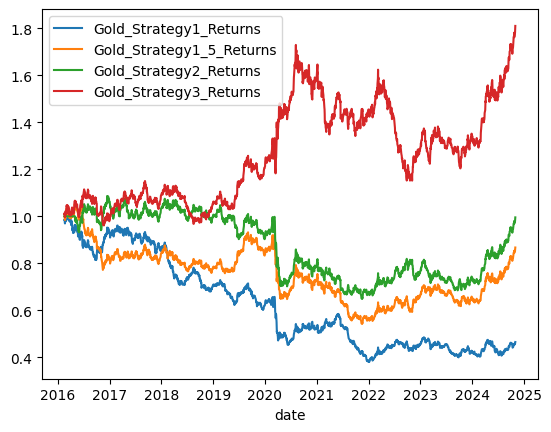

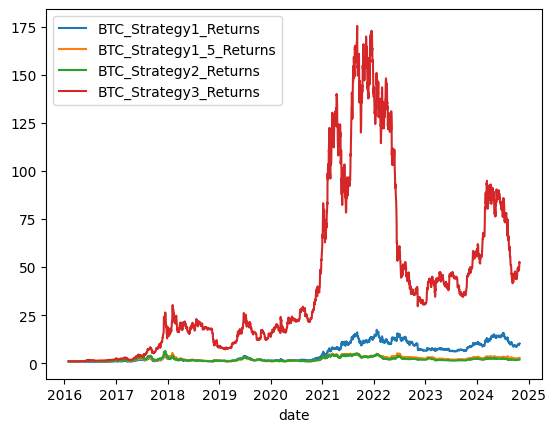

In [119]:
#plot the cumulative returns
gold_cumulative_returns.plot()
btc_cumulative_returns.plot()

In [120]:
#Sharpe
gold_sharpe = gold_all_returns.mean()*np.sqrt(252) / gold_all_returns.std()
btc_sharpe = btc_all_returns.mean() *np.sqrt(365) / btc_all_returns.std()

print(gold_sharpe)
print(btc_sharpe)

Gold_Strategy1_Returns     -0.534119
Gold_Strategy1_5_Returns   -0.041025
Gold_Strategy2_Returns      0.067577
Gold_Strategy3_Returns      0.544631
dtype: float64
BTC_Strategy1_Returns      0.730183
BTC_Strategy1_5_Returns    0.518900
BTC_Strategy2_Returns      0.459761
BTC_Strategy3_Returns      0.996046
dtype: float64


The BBAND stratgies appears to match with Holt winters model better, lets extend this strategy to other asset class

In [121]:
#Oil
oil = load_data('CL=F')[['Open' , 'Close']]
oil['daily_return'] = oil['Close'].pct_change()
oil['date'] = oil.index
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d').dt.date

oil.set_index('date', inplace=True)

#forecast the price for oil
oil['forecast'] = np.nan
oil = forecast_price(oil)

#BBAND strategy
oil[['bb_lower','bb_middle','bb_upper']] = ta.bbands(oil['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
Oil_Strategy_returns_holder = []

flag = 0

for i in range(len(oil)-1):
    if i < lookback:
        continue
    
    if oil['forecast'].iloc[i] < -0.0025 and oil['Close'].iloc[i] > oil['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Oil_Strategy_returns_holder.append(-oil['daily_return'].iloc[i+1] - tx_cost)

    elif (oil['Close'].iloc[i] < oil['bb_upper'].iloc[i]) and (oil['Close'].iloc[i] > oil['bb_middle'].iloc[i]) and (oil['forecast'].iloc[i] > 0.0025):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Oil_Strategy_returns_holder.append(oil['daily_return'].iloc[i+1] - tx_cost)

    elif (oil['Close'].iloc[i] < oil['bb_middle'].iloc[i]) and (oil['Close'].iloc[i] > oil['bb_lower'].iloc[i]) and (oil['forecast'].iloc[i] < -0.0025):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        Oil_Strategy_returns_holder.append(-oil['daily_return'].iloc[i+1] - tx_cost)

    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        Oil_Strategy_returns_holder.append(oil['daily_return'].iloc[i+1] - tx_cost)

Oil_Returns_df = pd.DataFrame(Oil_Strategy_returns_holder)
Oil_Returns_df.columns = ['Oil_Returns']
Oil_Returns_df.index = oil.index[lookback+1:]




In [122]:
#Results
print("Oil Strategy")
print("Mean: ", Oil_Returns_df['Oil_Returns'].mean()*np.sqrt(252))
print("SD: ", Oil_Returns_df['Oil_Returns'].std())
print("Sharpe: ", Oil_Returns_df['Oil_Returns'].mean()*np.sqrt(252)/Oil_Returns_df['Oil_Returns'].std())

Oil Strategy
Mean:  0.01290808812890536
SD:  0.0765945905278816
Sharpe:  0.16852480103286951


In [123]:
#ETH
eth = load_data('ETH-USD')[['Open' , 'Close']]
eth['daily_return'] = eth['Close'].pct_change()
eth['date'] = eth.index

eth['date'] = pd.to_datetime(eth['date'], format='%Y-%m-%d').dt.date

eth.set_index('date', inplace=True)

#forecast the price for eth
eth['forecast'] = np.nan
eth = forecast_price(eth)

#BBAND strategy
eth[['bb_lower','bb_middle','bb_upper']] = ta.bbands(eth['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
ETH_Strategy_returns_holder = []
flag = 0

for i in range(len(eth)-1):
    if i < lookback:
        continue

    if eth['forecast'].iloc[i] < -0.0025 and eth['Close'].iloc[i] > eth['bb_upper'].iloc[i]:
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        ETH_Strategy_returns_holder.append(-eth['daily_return'].iloc[i+1] - tx_cost)
    
    elif (eth['Close'].iloc[i] < eth['bb_upper'].iloc[i]) and (eth['Close'].iloc[i] > eth['bb_middle'].iloc[i]) and (eth['forecast'].iloc[i] > 0.0025):
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        ETH_Strategy_returns_holder.append(eth['daily_return'].iloc[i+1] - tx_cost)
    
    elif (eth['Close'].iloc[i] < eth['bb_middle'].iloc[i]) and (eth['Close'].iloc[i] > eth['bb_lower'].iloc[i]) and (eth['forecast'].iloc[i] < -0.0025):
        if flag != -1:
            tx_cost = 0.0025
            flag = -1
        else:
            tx_cost = 0
        ETH_Strategy_returns_holder.append(-eth['daily_return'].iloc[i+1] - tx_cost)
    
    else:
        if flag != 1:
            tx_cost = 0.0025
            flag = 1
        else:
            tx_cost = 0
        ETH_Strategy_returns_holder.append(eth['daily_return'].iloc[i+1] - tx_cost)


ETH_Returns_df = pd.DataFrame(ETH_Strategy_returns_holder)
ETH_Returns_df.columns = ['ETH_Returns']
ETH_Returns_df.index = eth.index[lookback+1:]





In [124]:
#Results
print("ETH Strategy")
print("Mean: ", ETH_Returns_df['ETH_Returns'].mean()*np.sqrt(365))
print("SD: ", ETH_Returns_df['ETH_Returns'].std())
print("Sharpe: ", ETH_Returns_df['ETH_Returns'].mean()*np.sqrt(365)/ETH_Returns_df['ETH_Returns'].std())

ETH Strategy
Mean:  0.03988005384746556
SD:  0.04582140962534411
Sharpe:  0.8703366870103371


### Final thought
The Holt winters model are not really fitted and accurate as the returns are not really stationary distribution.

The accuracy of the Holt winters model largely affect the performance of the strategies, we may further finetune the models or using other prediction model to replace in order to improve result.

But BBAND strategies shows the best results among others when it is applied together with Holt winters model predicting returns,
and the strategies appears to perform better in more volatile asset (crypto).